In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

theme, cs = rp.mpl_setup(True)

In [3]:
df1 = pd.read_feather('exps/delta_e_02-04-22-28/SAL-training_loss.feather')
df1

,epoch,Train,Partial_train,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,piezo,rsplt_ave
0,1,1227.160517,26613.241564,1053.333984,1057.038818,1043.132812,1056.944458,1064.404785,626.105530,1054.970972
1,2,129.951068,374.589167,154.890289,154.782761,151.274078,155.621582,159.266602,45.508251,155.167062
2,3,11.365085,52.024383,12.516207,12.398499,12.500477,12.625674,12.643608,16.809242,12.536893
3,4,17.474627,6.398860,20.147455,20.224127,19.765633,20.316919,20.599161,4.757285,20.210659
4,5,0.430345,4613.166391,1.896269,1.825629,1.898216,1.910301,1.935342,3.243062,1.893151
5,6,538.875589,404.709491,506.307556,506.199768,498.531403,508.843811,515.958923,344.830505,507.168292
6,7,299.392557,493.499236,332.336029,330.770874,328.847870,333.074768,337.172333,324.786926,332.440375
7,8,286.902768,415.720326,273.049011,273.460419,269.671509,274.851898,278.254883,214.230698,273.857544
8,9,588.394419,457.503436,705.197021,700.299927,693.725220,703.450439,711.976868,463.714081,702.929895
9,10,130.384441,1229.891223,130.045990,129.566818,128.741730,130.541458,131.526840,130.281830,130.084567


In [4]:
df2 = pd.read_feather('exps/delta_e_02-04-22-29/SAL-training_loss.feather')
df2

,epoch,Train,Partial_train,Rsplt1,Rsplt2,Rsplt3,Rsplt4,Rsplt5,piezo,rsplt_ave
0,1,1227.160517,26613.241564,1053.333984,1057.038818,1043.132812,1056.944458,1064.404785,626.105530,1054.970972
1,2,129.951068,374.589167,154.890289,154.782761,151.274078,155.621582,159.266602,45.508251,155.167062
2,3,11.365085,52.024383,12.516207,12.398499,12.500477,12.625674,12.643608,16.809242,12.536893
3,4,17.474627,6.398860,20.147455,20.224127,19.765633,20.316919,20.599161,4.757285,20.210659
4,5,0.430565,4613.208755,1.922539,1.850925,1.923267,1.935494,1.961205,3.201727,1.918686
5,6,5.125552,438.275741,5.453908,5.335474,5.555655,5.561742,5.513330,17.746410,5.484022
6,7,26.873518,235.585865,18.146454,18.282495,17.803944,18.348322,18.967241,10.699452,18.309691
7,8,834.631284,458.381178,844.765442,842.889832,832.411072,847.676392,857.554993,521.751221,845.059546
8,9,126.808560,432.527943,122.789917,122.747009,121.506203,123.831100,125.000771,113.355881,123.175000
9,10,1266.857021,203.949454,1646.802856,1632.673340,1619.043701,1647.149536,1667.438354,960.176208,1642.621558


/tmp/ipykernel_2747922/3334677224.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df1.applymap(np.log).plot()


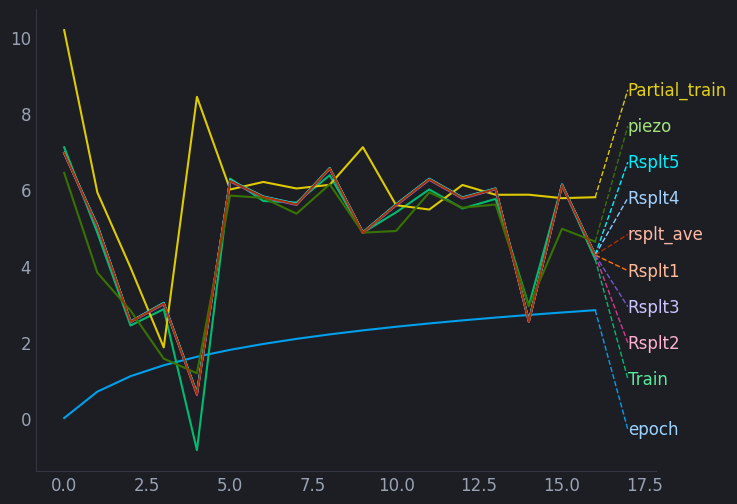

In [5]:
df1.applymap(np.log).plot()
rp.line_labels()

/tmp/ipykernel_2747922/381217083.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2.applymap(np.log).plot()


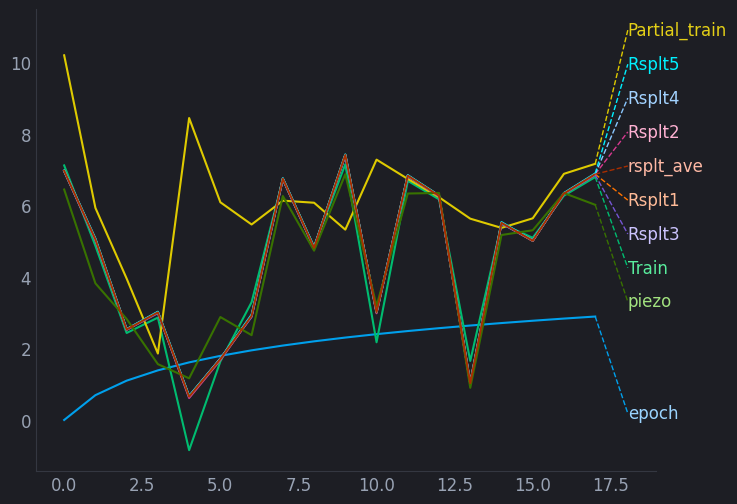

In [6]:
df2.applymap(np.log).plot()
rp.line_labels()

/tmp/ipykernel_2747922/4200216527.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2.applymap(lambda x: np.log10(x + 1)).plot()


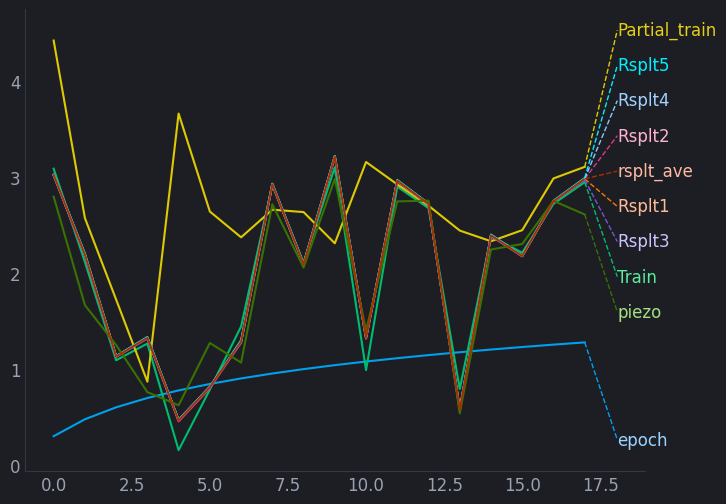

In [8]:
df = pd.read_feather('exps/delta_e_02-04-long/SAL-training_loss.feather')
df2.applymap(lambda x: np.log10(x + 1)).plot()
rp.line_labels()

In [11]:
import torch

pt = torch.load('exps/delta_e_02-04-long/Whole_SAL_957.pt')
pt

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      